In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [2]:
import os, sys
from IPython.display import clear_output
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
from pandas import DataFrame
import torch, torch.nn as nn
import numpy as np
import random
import networkx as nx
from utils_ac import random_walk, ReplayBuffer, PathsBuffer, get_states_emb, convert_to_walk, \
    is_valid_path, covering_walk, graph_isomorphism_algorithm_covers, relabel_graph, is_valid_path_new
from problem_ac import GraphProblem, generate_erdos_renyi_problems, generate_regular_problems, convert_graph
from generators_ac import connect_graph, generate_anonymous_walks
from network_ac import ActorCriticActLSTM, ActorCriticAct
import time
from collections import defaultdict as ddict

In [3]:
sys.path.insert(0, '..')
moving_average = lambda x, **kw: DataFrame({'x':np.asarray(x)}).x.ewm(**kw).mean().values

In [4]:
#params
NUM_PROBLEMS = 30
NUM_EPISODES = 20
NUM_VERTICES = 15
DEGREE = 6
THRESHOLD = 0.75
PATHS_BUFFER_CAPACITY = 100
REPLAY_BUFFER_CAPACITY = 100

In [5]:
problem_maker = generate_regular_problems(num_vertices=NUM_VERTICES, degree=DEGREE)

In [6]:
agent = ActorCriticAct(hid_size=256, gcn_size=256, vertex_emb_size=64)

In [7]:
optimizer = torch.optim.Adam(agent.parameters(), lr=1e-4)

In [8]:
#initialize buffers
path_buffer = PathsBuffer(capacity=PATHS_BUFFER_CAPACITY, threshold=THRESHOLD)
train_buffer = ReplayBuffer(capacity=REPLAY_BUFFER_CAPACITY)

In [9]:
actor_losses = []
critic_losses = []

In [10]:
problems = [next(problem_maker) for i in range(NUM_PROBLEMS)]

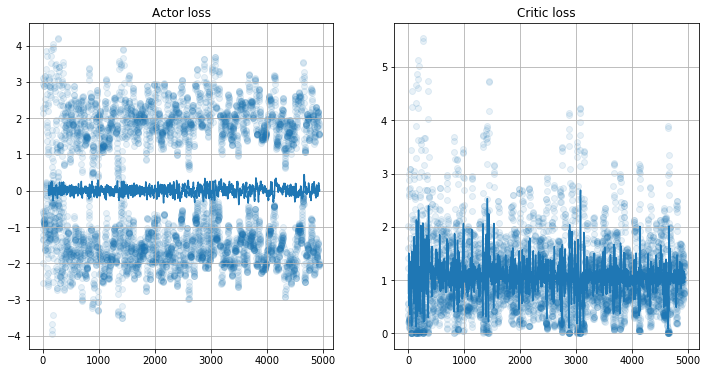

100%|██████████| 30/30 [3:14:48<00:00, 382.08s/it]


In [11]:
i = 0

for k in trange(len(problems)):
    
    problem = problems[k]
    
    edges = problem.get_edges()

    for vertex in problem.get_actions():

        path_buffer.flush()
        
        PATH_LENGTH = 2*problem.num_edges + 1        
        
        i += 1 
        
        for episode in range(NUM_EPISODES):
            
            problem.path = [vertex]
            
            source = problem.get_state()[0]
            
            states = []
            actions = []
            
            with torch.no_grad():
                graph_emb = agent.embed_graph(problem.edges)
            
            random_walk = [source]
            checked = ddict(list)
            stack = [source]
            visited = {source}
            ranks = {0: source} # to attempt to get maximal cover (possible to do without rank, but then no guarantees on maximality)
            revranks = {source: 0}

            while len(stack) > 0:
                last = stack[-1]
                lastrank = revranks[last]
                maxrank = max(ranks.keys()) + 1
                with torch.no_grad():
                    probs, _ = agent.get_dist([random_walk[:]], graph_emb, edges)
                probs = probs[0].data.numpy()
                Nlast = [x for _,x in sorted(zip(probs, edges[random_walk[:][-1]]), reverse=True)]
                #print("Is valid", all(i in edges[random_walk[:][-1]] for i in Nlast))
                # going in depth
                flag = False
                for neighbor in Nlast:
                    if neighbor not in visited:
                        states.append(random_walk[:])
                        actions.append(neighbor)
                        random_walk.append(neighbor)
                        stack.append(neighbor)
                        checked[last].append(neighbor)
                        visited.add(neighbor)
                        ranks[maxrank] = neighbor
                        revranks[neighbor] = maxrank
                        flag = True
                        break

                # interconnecting nodes that are already in walk
                if not flag:
                    for r in range(maxrank-1, lastrank+1, -1):
                        node = ranks[r]
                        if node not in checked[last] and node in Nlast:
                            checked[last].append(node)
                            random_walk.extend([node, last])

                if not flag:
                    stack.pop()
                    if len(stack) > 0:
                        random_walk.append(stack[-1])
                        checked[last].append(stack[-1])
                        
            path_buffer.push(random_walk)
            
            if len(path_buffer) >= 10:
                reward = path_buffer.rank_path(random_walk)
                rewards = torch.FloatTensor([reward]*(len(states)))
                graph_emb = agent.embed_graph(problem.edges)
                
                probs, values = agent.get_dist(states, graph_emb, edges)
                log_probs = []
                for i, dist in enumerate(probs):
                    valids = edges[states[i][-1]]
                    a = valids.index(actions[i])
                    m = torch.distributions.Categorical(dist)
                    log_prob = m.log_prob(torch.tensor(a))
                    log_probs.append(log_prob)

                advantage = rewards - values

                actor_loss  = -(torch.stack(log_probs) * advantage.detach()).mean()
                critic_loss = advantage.pow(2).mean()
                                                          
                actor_losses.append(actor_loss.item())
                critic_losses.append(critic_loss.item())

                loss = actor_loss + critic_loss

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
            if i % 2 == 0:
                clear_output(True)
                plt.figure(figsize=[12, 6])
                plt.subplot(1,2,1)
                plt.title('Actor loss'); plt.grid()
                plt.scatter(np.arange(len(actor_losses)), actor_losses, alpha=0.1)
                plt.plot(moving_average(actor_losses, span=100, min_periods=100))

                plt.subplot(1,2,2)
                plt.title('Critic loss'); plt.grid()
                plt.scatter(np.arange(len(critic_losses)), critic_losses, alpha=0.1)
                plt.plot(moving_average(critic_losses, span=10, min_periods=10))
                plt.show()

In [26]:
probs

[tensor([0.1627, 0.1573, 0.1699, 0.1676, 0.1719, 0.1705],
        grad_fn=<ViewBackward>),
 tensor([0.1564, 0.1582, 0.1721, 0.1667, 0.1710, 0.1756],
        grad_fn=<ViewBackward>),
 tensor([0.1652, 0.1662, 0.1639, 0.1696, 0.1682, 0.1668],
        grad_fn=<ViewBackward>),
 tensor([0.1610, 0.1611, 0.1712, 0.1681, 0.1687, 0.1700],
        grad_fn=<ViewBackward>),
 tensor([0.1580, 0.1636, 0.1599, 0.1743, 0.1728, 0.1714],
        grad_fn=<ViewBackward>),
 tensor([0.1676, 0.1646, 0.1623, 0.1680, 0.1665, 0.1710],
        grad_fn=<ViewBackward>),
 tensor([0.1588, 0.1687, 0.1691, 0.1663, 0.1649, 0.1722],
        grad_fn=<ViewBackward>),
 tensor([0.1632, 0.1595, 0.1693, 0.1703, 0.1680, 0.1697],
        grad_fn=<ViewBackward>),
 tensor([0.1653, 0.1597, 0.1616, 0.1715, 0.1702, 0.1717],
        grad_fn=<ViewBackward>),
 tensor([0.1588, 0.1644, 0.1606, 0.1747, 0.1709, 0.1707],
        grad_fn=<ViewBackward>),
 tensor([0.1602, 0.1662, 0.1673, 0.1707, 0.1664, 0.1692],
        grad_fn=<ViewBackward>),

In [15]:
print(path_buffer.is_paths_buffer_valid(edges))

True


In [ ]:
path_buffer.buffer.sort(key = lambda x: convert_to_walk(x))

In [30]:
for i in range(len(path_buffer)-1):
    flag = True
    if path_buffer.buffer[i] != path_buffer.buffer[i+1]:
        flag = False
print(flag)

True


In [17]:
edges

{5: [1, 2, 3, 4, 9, 12],
 9: [0, 1, 3, 5, 7, 12],
 2: [0, 5, 6, 8, 12, 13],
 12: [2, 3, 5, 6, 7, 9],
 1: [0, 5, 9, 10, 13, 14],
 4: [5, 6, 7, 8, 10, 11],
 3: [0, 5, 9, 10, 12, 13],
 7: [4, 9, 10, 11, 12, 14],
 0: [1, 2, 3, 8, 9, 14],
 8: [0, 2, 4, 6, 11, 13],
 10: [1, 3, 4, 7, 13, 14],
 11: [4, 6, 7, 8, 13, 14],
 6: [2, 4, 8, 11, 12, 14],
 14: [0, 1, 6, 7, 10, 11],
 13: [1, 2, 3, 8, 10, 11]}

In [29]:
path_buffer.is_paths_buffer_sorted()

True

In [22]:
def test_agent(agent, problem, vertex):
    
    with torch.no_grad():
        graph_emb = agent.embed_graph(problem.edges)
        problem.path = [vertex]
        source = problem.get_state()[0]
        random_walk = [source]
        checked = ddict(list)
        stack = [source]
        visited = {source}
        edges = problem.get_edges()
        ranks = {0: source} # to attempt to get maximal cover (possible to do without rank, but then no guarantees on maximality)
        revranks = {source: 0}
        
        while len(stack) > 0:
            last = stack[-1]
            lastrank = revranks[last]
            maxrank = max(ranks.keys()) + 1
            probs, _ = agent.get_dist([random_walk[:]], graph_emb, edges) 
            probs = probs[0].data.numpy()
            print(probs)
            Nlast = [x for _,x in sorted(zip(probs, edges[random_walk[:][-1]]), reverse=True)]
            # going in depth
            flag = False
            for neighbor in Nlast:
                if neighbor not in visited:
                    random_walk.append(neighbor)
                    stack.append(neighbor)
                    checked[last].append(neighbor)
                    visited.add(neighbor)
                    ranks[maxrank] = neighbor
                    revranks[neighbor] = maxrank
                    flag = True
                    break

                # interconnecting nodes that are already in walk
            if not flag:
                for r in range(maxrank-1, lastrank+1, -1):
                    node = ranks[r]
                    if node not in checked[last] and node in Nlast:
                        checked[last].append(node)
                        random_walk.extend([node, last])

            if not flag:
                stack.pop()
                if len(stack) > 0:
                    random_walk.append(stack[-1])
                    checked[last].append(stack[-1])
        return random_walk

In [23]:
p = next(problem_maker)

In [24]:
v = 6

In [25]:
path = test_agent(agent, p, v)

NameError: name 'hidden' is not defined

In [ ]:
is_valid_path(path, p)

In [ ]:
G = nx.random_regular_graph(6, 40)
G2 = relabel_graph(G)
print(15, graph_isomorphism_algorithm_covers(G, G2, agent, test_agent, 1))